In [3]:
import pandas as pd

In [4]:
import numpy as np

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

In [93]:
import tensorflow as tf

/home/prasoon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [61]:
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('Desktop/training.csv')

In [6]:
df_test = pd.read_csv('Desktop/test_kaggle.csv')

In [44]:
df = df.dropna()

In [45]:
l = []
for image in df['Image']:
    l.append(list(map(int,list(image.split()))))
    

In [76]:
Y_train_pre = np.array(df.ix[:,:'mouth_center_bottom_lip_y'])
Y_train_pre.shape

(2140, 30)

In [51]:
X_train_pre = np.array(l)


In [52]:
X_train_pre.shape

(2140, 9216)

In [53]:
X_train_pre = X_train_pre.reshape(2140,96,96)

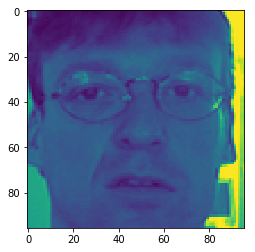

In [58]:
index = 15
plt.imshow(X_train_pre[index])


In [59]:
X_train_flatten = X_train_pre.reshape(X_train_pre.shape[0],-1).T

In [60]:
X_train_flatten_new = X_train_flatten/255


In [63]:
X_train_orig,X_test,y_train_orig,y_test = train_test_split(X_train_flatten_new.T,Y_train_pre,test_size=0.2)

In [65]:
X_train,X_val,y_train,y_val = train_test_split(X_train_orig,y_train_orig,test_size = 0.2)

In [109]:
X_train = X_train.T

In [102]:
X_val = X_val.T

In [108]:
y_train = y_train.T

In [104]:
y_val = y_val.T

In [111]:
X_test = X_test.T

In [115]:
y_test = y_test.T

In [94]:
def create_placeholders(n_x,n_y):
    X = tf.placeholder(tf.float32,shape=[n_x,None],name='X')
    Y = tf.placeholder(tf.float32,shape=[n_y,None],name='Y')
    return X,Y

In [95]:
def initialize_parameters(layers_dims):
    parameters={}
    for l in range(len(layers_dims)-1):
        parameters["W"+str(l+1)] = tf.get_variable('W'+str(l+1),[layers_dims[l+1],layers_dims[l]],initializer = tf.contrib.layers.xavier_initializer())
        parameters["b"+str(l+1)] = tf.get_variable("b"+str(l+1),[layers_dims[l+1],1],initializer = tf.zeros_initializer())
    return parameters

In [96]:
def forward_propagation(X,parameters,layers_dims):
    cache = {}
    cache["A0"] = X
    for l in range(len(layers_dims)-1):
        cache["Z"+str(l+1)] = tf.add(tf.matmul(parameters["W"+str(l+1)],cache["A"+str(l)]),parameters["b"+str(l+1)])
        if (l == len(layers_dims)-2):
            return cache["Z"+str(l+1)]
        cache["A"+str(l+1)] = tf.nn.relu(cache["Z"+str(l+1)])
        

In [106]:
def compute_cost(ZL,Y):
    cost = tf.reduce_mean(tf.losses.mean_squared_error(predictions = tf.transpose(ZL), labels = tf.transpose(Y)))
    return cost

In [101]:
def random_minibatch(X_train,Y_train,minibatch_size,num_minibatches):
    minibatches = []
    random_shuffle = np.concatenate((X_train.T,Y_train.T),axis=1)
    np.random.shuffle(random_shuffle)
    random_shuffle_X = random_shuffle[:,0:X_train.shape[0]].T
    random_shuffle_Y = random_shuffle[:,X_train.shape[0]:X_train.shape[0]+Y_train.shape[0]].T
    for i in range(num_minibatches):
        minibatch_X = random_shuffle_X[:,i*minibatch_size:minibatch_size*(i+1)]
        minibatch_Y = random_shuffle_Y[:,i*minibatch_size:minibatch_size*(i+1)]
        minibatch = (minibatch_X,minibatch_Y)
        minibatches.append(minibatch)
    if (Y_train.shape[1]/num_minibatches != 0):
        minibatch_X = random_shuffle_X[:,num_minibatches*minibatch_size:X_train.shape[1]]
        minibatch_Y = random_shuffle_Y[:,num_minibatches*minibatch_size:Y_train.shape[1]]
        minibatch = (minibatch_X,minibatch_Y)
        minibatches.append(minibatch)
    return minibatches

In [99]:
def model(X_train,Y_train,X_test,Y_test,learning_rate,num_epochs,minibatch_size,print_cost,layers_dims):
    tf.reset_default_graph()
    (n_x,m) = X_train.shape
    n_y = Y_train.shape[0]
    costs =[]
    X,Y = create_placeholders(n_x,n_y)
    parameters = initialize_parameters(layers_dims)
    ZL = forward_propagation(X,parameters,layers_dims)
    cost = compute_cost(ZL,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    num_minibatches = int(m/minibatch_size)
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0
            minibatches = random_minibatch(X_train,Y_train,minibatch_size,num_minibatches)
            for minibatch in minibatches:
                (minibatch_X,minibatch_Y) = minibatch
                _,minibatch_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                epoch_cost = epoch_cost + minibatch_cost/num_minibatches
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
                

Cost after epoch 0: 407.885095
Cost after epoch 100: 5.330714
Cost after epoch 200: 4.844535
Cost after epoch 300: 5.930957
Cost after epoch 400: 8.983941


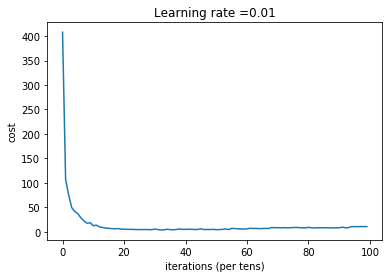

Train Accuracy: 0.6932067
Test Accuracy: 0.7266355


In [117]:
model(X_train,y_train,X_test,y_test,0.01,500,32,True,[9216,100,50,30])